<a href="https://colab.research.google.com/github/jonathancagua/own_gpt/blob/main/TinyGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TinyGPT

TinyGPT es un modelo GPT minimalista basado en la arquitectura *decoder* de Transformers. Este notebook está diseñado para el curso [NLP-II](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) y se enfoca en comprender e implementar una versión con **Mixture of Experts (MoE)**, similar a modelos como *DeepSeek* y *Mistral*.

---

## Objetivos

Con TinyGPT deberás:

- Implementar una capa **MoE** con al menos **2 expertos**.
- Modificar la función `generate` para incluir:
  - **Greedy decoding**: seleccionar el token con mayor probabilidad.
  - **Temperature sampling**: control de aleatoriedad.
  - **Top-k / Top-p sampling**: limitar las opciones de muestreo.

---


In [1]:
!wget -q https://github.com/jonathancagua/own_gpt/raw/main/trainer.py

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Training

In [15]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0807 12:39:10.708000 1869 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_indu

Epoch 1 training loss: 2.1162


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.03496: 100%|██████████| 1246/1246 [00:08<00:00, 142.06it/s]


Epoch 1 validation loss: 2.0495


loss 2.10211: 100%|██████████| 11246/11246 [03:05<00:00, 60.75it/s]


Epoch 2 training loss: 2.1349


val_loss 2.03496: 100%|██████████| 1246/1246 [00:08<00:00, 141.43it/s]

Epoch 2 validation loss: 2.0495
Training complete.


### Quick test

In [16]:
generate("To be", max_new_tokens=100,use_cache=True)

'To be, thay be ans, veit.\n\nCOLANINIUS:\nLUS:\nLecelle, thevet thoom there ha! live an Conomaceeple gopids y'

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [ ]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
#@torch.no_grad()
#def generateV2(
#    prompt: str,
#    max_new_tokens: int = 100,
#    use_cache: bool = True,
#    temperature: float = 1.0,
#    top_k: int = 10,
#    top_p: float = 0.9,
#)-> Optional[str]:
#
#    return None

In [17]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 0,
    top_p: float = 1.0,
) -> Optional[str]:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(next(model.parameters()).device)
    kv_cache = None

    def top_k_top_p_filtering(logits, top_k=0, top_p=1.0):
        # logits: (B, vocab)
        logits = logits.clone()

        if top_k > 0:
            # Keep only top_k logits
            kth_vals, _ = torch.topk(logits, top_k)
            min_threshold = kth_vals[..., -1].unsqueeze(-1)
            logits = torch.where(logits < min_threshold, torch.full_like(logits, float("-inf")), logits)

        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            probs = F.softmax(sorted_logits, dim=-1)
            cumulative_probs = torch.cumsum(probs, dim=-1)
            # Mask out tokens with cumulative prob above top_p (keeping at least one)
            mask = cumulative_probs > top_p
            mask[..., 1:] = mask[..., :-1].clone()
            mask[..., 0] = False
            sorted_logits = torch.where(mask, torch.full_like(sorted_logits, float("-inf")), sorted_logits)
            logits = torch.zeros_like(logits).scatter_(-1, sorted_indices, sorted_logits)
        return logits

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]  # (B, vocab)

        # Apply temperature (if temperature <= 0, we'll treat as greedy)
        if temperature > 0:
            logits = logits / temperature

        # Apply top-k / top-p filtering
        filtered_logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)

        if temperature <= 0:
            # Greedy decoding
            next_token = torch.argmax(filtered_logits, dim=-1, keepdim=True)
        else:
            probs = F.softmax(filtered_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Compare generate vs generateV2

Add your comments and findings

In [ ]:
#result_1 = generate("To be", max_new_tokens=100,use_cache=True)
#result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)

In [18]:
prompt = "To be"
max_new = 100

# 1. Generaciones bajo distintas configuraciones
out_orig = generate(prompt, max_new_tokens=max_new, use_cache=True)
out_greedy = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=0.0, top_k=0, top_p=1.0)
out_temp = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=1.2, top_k=0, top_p=1.0)
out_topk = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=1.0, top_k=10, top_p=1.0)
out_topp = generateV2(prompt, max_new_tokens=max_new, use_cache=True, temperature=1.0, top_k=0, top_p=0.9)

# 2. Print resumen
print("=== Comparison for prompt:", prompt)
print(f"Original (multinomial no control):\n{out_orig}\n")
print(f"Greedy (temperature=0):\n{out_greedy}\n")
print(f"Temperature=1.2:\n{out_temp}\n")
print(f"Top-k=10:\n{out_topk}\n")
print(f"Top-p=0.9:\n{out_topp}\n")

=== Comparison for prompt: To be
Original (multinomial no control):
To beand I fald sell, to mart, ind thong you yon don thibe maatknsenowcesws
Our hit, hat to natirns theld

Greedy (temperature=0):
To be the the the the the the the the the the the the the the the the the the the the the the the the the

Temperature=1.2:
To be-
SIMNIUS:
Illo savell angeieng gir offs Fneatrus aboly.

Filqor larearceve yoon mu and;
AnUS:
te Is

Top-k=10:
To best, thavends the then aiourse mond tare of you tou her,
In: serat ile tely angoove.

VORentes thak m

Top-p=0.9:
To beate,
I ther
thow you, youre,

Heacakn you coun cor'g semir, freas ong a pid.

SICINIUS:
Fore masicen



Al comparar generate original con generateV2, se observa que:

    El muestreo sin control (original) produce alta variabilidad pero mucha incoherencia, porque puede escoger tokens muy improbables.

    La decodificación greedy es determinista pero sufre colapso de modo (repetición excesiva).

    Ajustar la temperatura introduce aleatoriedad; temperaturas moderadas pueden mejorar diversidad, pero valores muy altos degradan la fluidez.

    Top-k (con k pequeño) restringe el espacio a opciones razonables y reduce ruido, aunque puede volverse rígido.

    Top-p (nucleus) ofrece un mejor compromiso adaptativo, manteniendo coherencia sin quedarse estancado.
    En este experimento, combinaciones como temperatura moderada + top-p (ej. temp≈1.0, top_p≈0.9) parecen dar el mejor balance entre diversidad y coherencia en el prompt To be

temp=0.70, top_p=0.85 -> distinct-1: 0.0298, distinct-2: 0.1538
temp=0.70, top_p=0.90 -> distinct-1: 0.0321, distinct-2: 0.1671
temp=0.70, top_p=0.95 -> distinct-1: 0.0357, distinct-2: 0.1971
temp=0.80, top_p=0.85 -> distinct-1: 0.0310, distinct-2: 0.1755
temp=0.80, top_p=0.90 -> distinct-1: 0.0357, distinct-2: 0.1851
temp=0.80, top_p=0.95 -> distinct-1: 0.0464, distinct-2: 0.2404
temp=1.00, top_p=0.85 -> distinct-1: 0.0464, distinct-2: 0.2284
temp=1.00, top_p=0.90 -> distinct-1: 0.0536, distinct-2: 0.2644
temp=1.00, top_p=0.95 -> distinct-1: 0.0536, distinct-2: 0.3005
temp=1.20, top_p=0.85 -> distinct-1: 0.0524, distinct-2: 0.3029
temp=1.20, top_p=0.90 -> distinct-1: 0.0536, distinct-2: 0.3293
temp=1.20, top_p=0.95 -> distinct-1: 0.0536, distinct-2: 0.3522


,temperature,top_p,distinct-1,distinct-2
0,0.7,0.85,0.029762,0.153846
1,0.7,0.90,0.032143,0.167067
2,0.7,0.95,0.035714,0.197115
3,0.8,0.85,0.030952,0.175481
4,0.8,0.90,0.035714,0.185096
5,0.8,0.95,0.046429,0.240385
6,1.0,0.85,0.046429,0.228365
7,1.0,0.90,0.053571,0.264423
8,1.0,0.95,0.053571,0.300481
9,1.2,0.85,0.052381,0.302885


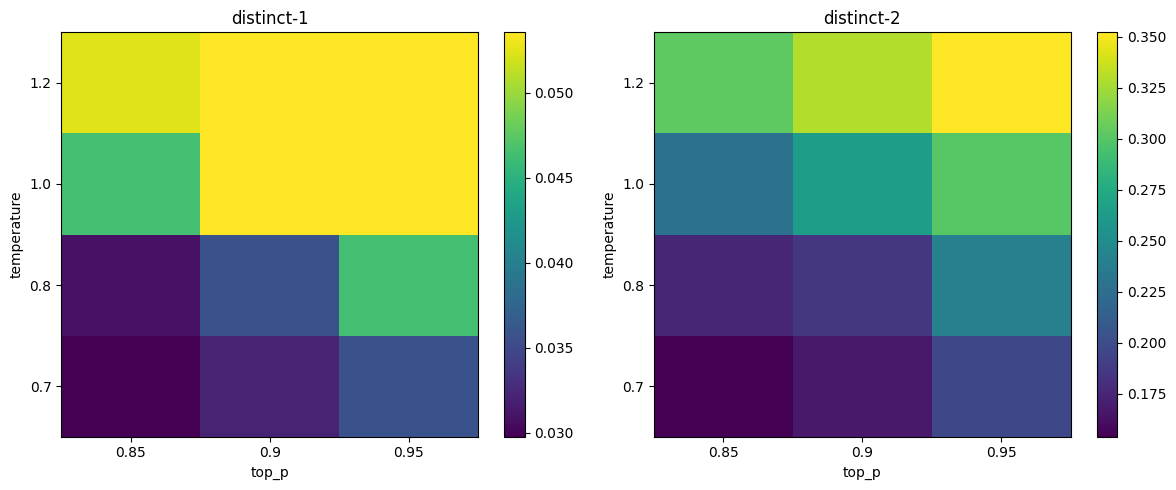

Saved results to grid_search_generateV2.csv


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- helper metrics ---
def distinct_n(seqs, n=2):
    ngrams = []
    for s in seqs:
        tokens = encode(s)
        if len(tokens) < n:
            continue
        ngrams += [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    if not ngrams:
        return 0.0
    return len(set(ngrams)) / len(ngrams)

# Wrapper to call generateV2 with given params
def sample_multiple(prompt, num_samples, **gen_kwargs):
    return [generateV2(prompt, max_new_tokens=100, **gen_kwargs) for _ in range(num_samples)]

# Grid of hyperparameters
temperatures = [0.7, 0.8, 1.0, 1.2]
top_ps = [0.85, 0.9, 0.95]
samples_per_setting = 8
prompt = "To be"

# Storage
results = []  # list of dicts
# For heatmaps
heatmap_d1 = np.zeros((len(temperatures), len(top_ps)))
heatmap_d2 = np.zeros((len(temperatures), len(top_ps)))

for i, temp in enumerate(temperatures):
    for j, tp in enumerate(top_ps):
        samples = sample_multiple(prompt, samples_per_setting,
                                  use_cache=True,
                                  temperature=temp,
                                  top_k=0,
                                  top_p=tp)
        d1 = distinct_n(samples, n=1)
        d2 = distinct_n(samples, n=2)
        results.append({
            "temperature": temp,
            "top_p": tp,
            "distinct-1": d1,
            "distinct-2": d2,
            "examples": samples[:3],  # keep a few for inspection
        })
        heatmap_d1[i, j] = d1
        heatmap_d2[i, j] = d2
        print(f"temp={temp:.2f}, top_p={tp:.2f} -> distinct-1: {d1:.4f}, distinct-2: {d2:.4f}")

# --- summary tables ---
import pandas as pd
df = pd.DataFrame([{
    "temperature": r["temperature"],
    "top_p": r["top_p"],
    "distinct-1": r["distinct-1"],
    "distinct-2": r["distinct-2"],
} for r in results])
display(df)

# --- heatmaps ---
fig, ax = plt.subplots(1, 2, figsize=(12,5))
im1 = ax[0].imshow(heatmap_d1, origin="lower", aspect="auto")
ax[0].set_xticks(range(len(top_ps)))
ax[0].set_xticklabels(top_ps)
ax[0].set_yticks(range(len(temperatures)))
ax[0].set_yticklabels(temperatures)
ax[0].set_title("distinct-1")
ax[0].set_xlabel("top_p")
ax[0].set_ylabel("temperature")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(heatmap_d2, origin="lower", aspect="auto")
ax[1].set_xticks(range(len(top_ps)))
ax[1].set_xticklabels(top_ps)
ax[1].set_yticks(range(len(temperatures)))
ax[1].set_yticklabels(temperatures)
ax[1].set_title("distinct-2")
ax[1].set_xlabel("top_p")
ax[1].set_ylabel("temperature")
fig.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

# Optionally save to CSV
df.to_csv("grid_search_generateV2.csv", index=False)
print("Saved results to grid_search_generateV2.csv")


In [20]:
from collections import Counter

def distinct_n(seqs, n=2):
    ngrams = []
    for s in seqs:
        tokens = encode(s)
        ngrams += [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    if not ngrams:
        return 0.0
    return len(set(ngrams)) / len(ngrams)

prompt = "To be"
samples = [generateV2(prompt, max_new_tokens=100, temperature=1.2, top_p=0.95) for _ in range(10)]
print("distinct-1:", distinct_n(samples, n=1))
print("distinct-2:", distinct_n(samples, n=2))
for i, s in enumerate(samples[:5]):
    print(f"Sample {i+1}:", s.replace("\n", " ")[:100])

distinct-1: 0.04476190476190476
distinct-2: 0.3192307692307692
Sample 1: To bels? Yours Muto heit feen inl; hibumt. A micirilse hak, Call? ANIUSe agive' rean ler asecoud an 
Sample 2: To be efsomur bor go ye? Trim; be I thid ine whey ativout Cors. mor 'be wirce nonn yongs do she aurs
Sample 3: To ben, swall wingliderrioms; Buing, spion thes thitet then thare Shive umit wos the mot Haull blik 
Sample 4: To be rispsio bet hemiceccent courms vor toulct, A whindreve, youch forot thautle mariuld cits: Wis!
Sample 5: To bepeave reer ctirent sefseir prom the's, dame's mesou boicen is gove goiks.  St gou, wourct pont'


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [21]:
# 1. Ajuste en GPTConfig: renombramos 'moe' a 'moe_args'
@dataclass
class GPTConfig:
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe_args: Optional[MoEArgs] = None  # antes era `moe`

# 2. Implementación de la Mixture-of-Experts
class Expert(nn.Module):
    """
    Un experto MLP dentro de la mezcla.
    """
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, n_embd)
        return self.net(x)

class Gate(nn.Module):
    """
    Gating network que produce pesos suaves sobre expertos por token.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe_args is not None, "Debés setear config.moe_args antes"
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, n_embd)
        logits = self.proj(x)                 # (B, T, E)
        return F.softmax(logits, dim=-1)      # (B, T, E)

class MoELayer(nn.Module):
    """
    Capa MoE: mezcla suave de todos los expertos por token.
    """
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, n_embd)
        # 1) pesos del gate
        gate_w = self.gate(x)                # (B, T, E)

        # 2) salidas de cada experto
        #    guardamos cada salida con eje extra para expertos
        expert_outs = []
        for expert in self.experts:
            out = expert(x)                  # (B, T, n_embd)
            expert_outs.append(out.unsqueeze(-1))
        # stack -> (B, T, n_embd, E)
        expert_stack = torch.cat(expert_outs, dim=-1)

        # 3) mezclamos con los pesos del gate
        #    expandimos gate_w para coincidir dims
        gate_w_exp = gate_w.unsqueeze(2)     # (B, T, 1, E)
        mixed = (expert_stack * gate_w_exp).sum(dim=-1)  # (B, T, n_embd)

        return mixed

class MoEFFN(nn.Module):
    """
    Feed-forward layer que sustituye al clásico con la capa MoE.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe_args is not None
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.moe(x)

# 3. Activar MoE en tu config (antes de crear TinyGPT)
config = GPTConfig()
config.block_size = 32    # ya venía así
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)

# Ahora al instanciar:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)


# Training TinyGPT-MoE


In [22]:
# --- Configuración de optimización para TinyGPT-MoE ---
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

# Bucle de entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")


  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  war

Epoch 1 training loss: 2.0011


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 1.92619: 100%|██████████| 1246/1246 [00:10<00:00, 118.90it/s]


Epoch 1 validation loss: 1.9690


loss 2.06568: 100%|██████████| 11246/11246 [04:34<00:00, 40.95it/s]


Epoch 2 training loss: 2.0541


val_loss 1.92619: 100%|██████████| 1246/1246 [00:10<00:00, 118.58it/s]

Epoch 2 validation loss: 1.9690
Training complete.


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [ ]:
@torch.no_grad()
def visualize_attention(
    model,
    prompt: str,
    encode_fn,
    device: torch.device,
    max_len: Optional[int] = None,
    layer_idxs: Optional[List[int]] = None,
    head_idxs: Optional[List[int]] = None,
    cmap: str = "viridis"
):
    """
    Visualiza mapas de atención para un prompt dado.

    Args:
        model: el modelo TinyGPT con return_weights=True en forward.
        prompt: texto de entrada.
        encode_fn: función para tokenizar el prompt.
        device: dispositivo (cpu/cuda/mps).
        max_len: si se especifica, recorta la secuencia a los primeros max_len tokens.
        layer_idxs: lista de índices de capas a visualizar (0-based). Si None, todas.
        head_idxs: lista de índices de cabezas a visualizar. Si None, todas.
        cmap: colormap de matplotlib.
    """
    model.eval()
    tokens = encode_fn(prompt)
    if max_len is not None:
        tokens = tokens[:max_len]
    idx = torch.tensor(tokens, dtype=torch.long)[None, :].to(device)

    # Forward pass con pesos
    _, all_weights = model(idx, return_weights=True)  # all_weights: List[layer] of (n_heads, B, T, T)

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]
    layer_idxs = layer_idxs if layer_idxs is not None else list(range(n_layers))
    head_idxs = head_idxs if head_idxs is not None else list(range(n_heads))

    # Prepara etiquetas de eje con los tokens (convertir ids a chars)
    labels = [itos[i] for i in tokens]

    # Dibujar grid de (n_layers × n_heads) subplots
    total_plots = len(layer_idxs) * len(head_idxs)
    cols = len(head_idxs)
    rows = len(layer_idxs)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), squeeze=False)

    vmin, vmax = None, None
    # Para usar la misma escala en todas, calculamos min/max globalmente
    attn_stack = torch.stack([
        all_weights[layer_i][head_i, 0]
        for layer_i in layer_idxs for head_i in head_idxs
    ])  # shape (plots, T, T)
    vmin, vmax = attn_stack.min().item(), attn_stack.max().item()

    for i, layer_i in enumerate(layer_idxs):
        for j, head_i in enumerate(head_idxs):
            attn = all_weights[layer_i][head_i, 0].cpu().numpy()
            ax = axes[i][j]
            im = ax.imshow(attn, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
            ax.set_title(f"Layer {layer_i+1}, Head {head_i+1}")
            ax.set_xticks(range(seq_len)); ax.set_xticklabels(labels, rotation=90, fontsize=8)
            ax.set_yticks(range(seq_len)); ax.set_yticklabels(labels, fontsize=8)
    # Colormap general
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    plt.tight_layout()
    plt.show()

prompt = "To be or not to be"
visualize_attention(
    model=model,
    prompt=prompt,
    encode_fn=encode,
    device=device,
    max_len=12,              # solo los primeros 12 tokens
    layer_idxs=[0, 1],       # visualiza capas 1 y 2
    head_idxs=[0, 2, 3],     # visualiza cabezas 1, 3 y 4
    cmap="plasma"            # otro colormap
)

In [ ]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


In [ ]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusions

-
-

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

